# предобработка данных

In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import scipy.sparse as sp
from tqdm.notebook import tqdm
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.metrics import fbeta_score

In [32]:
import string
import nltk
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

In [33]:
import warnings
warnings.filterwarnings("ignore")

In [34]:
from sklearn.datasets import fetch_20newsgroups
number_of_topic = 3
newsgroups_train = fetch_20newsgroups(subset='train')
indices = np.where((newsgroups_train.target >= 0) & (newsgroups_train.target <= number_of_topic))[0]
texts = [newsgroups_train.data[i] for i in indices]
target = np.array([newsgroups_train.target[i] for i in indices])
print(f"Всего элементов: {target.shape[0]}")
for i in range(number_of_topic):
    count = np.count_nonzero(target == i)
    print(f"ко-во элементов из класса {i}: {count}")

Всего элементов: 2245
ко-во элементов из класса 0: 480
ко-во элементов из класса 1: 584
ко-во элементов из класса 2: 591


In [35]:
def lemmatize_tokens(tokens):
    lemmatizer = WordNetLemmatizer()

    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return lemmatized_tokens


def preprocess_text(text): 
    # Удаление пунктуации
    text = re.sub(r'[^\w\s]', '', text)
    
    tokens = word_tokenize(text)

    stop_words = set(stopwords.words('english'))
    
    tokens = [token for token in tokens if token not in stop_words]

    lemmatized_tokens = lemmatize_tokens(tokens)
    
    return lemmatized_tokens

In [36]:
tokenized_corpus = [preprocess_text(i) for i in texts]
tokenized_corpus[0][:5]

['From', 'jgreenamber', 'Joe', 'Green', 'Subject']

# представление данных LDA

In [37]:
def lda_repo(tokenized_corpus, num_topics=15):
    # Создание словаря
    dictionary = Dictionary(tokenized_corpus)
    
    # Преобразование текстов в мешок слов
    bow_corpus = [dictionary.doc2bow(text) for text in tokenized_corpus]
    
    # Обучение модели LDA
    lda_model = LdaModel(
        corpus=bow_corpus,  # Мешок слов
        id2word=dictionary,  # Словарь
        num_topics=num_topics,  # Количество тем
        passes=10,  # Количество итераций по корпусу
        iterations=100,  # Количество итераций для оценки параметров
        random_state=42  # Зафиксированный случайный seed для воспроизводимости результатов
    )
    return lda_model, bow_corpus

In [38]:
best_param = 1810
lda_model, bow_corpus = lda_repo(tokenized_corpus, best_param)

In [39]:
# получаем тематические векторы
lda_vec = []
for i in tqdm(range(len(target))):
    doc_topics = lda_model.get_document_topics(bow_corpus[i])
    doc_vec = np.zeros(best_param)
    for topic, prob in doc_topics:
        #top_numb = int(re.sub(r'[a-zA-Z]', '', topic))
        doc_vec[topic] = prob
    lda_vec.append(doc_vec)

  0%|          | 0/2245 [00:00<?, ?it/s]

# представление данных lsi

In [41]:
def lemmatize_tokens(tokens):
    lemmatizer = WordNetLemmatizer()

    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return lemmatized_tokens


def preprocess_text(text): 
    # Удаление пунктуации
    text = re.sub(r'[^\w\s]', '', text)
    
    tokens = word_tokenize(text)

    stop_words = set(stopwords.words('english'))
    
    tokens = [token for token in tokens if token not in stop_words]

    lemmatized_tokens = lemmatize_tokens(tokens)
    
    return " ".join(lemmatized_tokens)

In [43]:
corpus = [preprocess_text(i) for i in texts]
corpus[0][:60]

'From jgreenamber Joe Green Subject Re Weitek P9000 Organizat'

In [44]:
tfidf_vectorizer = TfidfVectorizer()

tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)

In [45]:
mini_size = 1646 # best size

In [46]:
lsa_model = TruncatedSVD(n_components=mini_size)
lsa_vectors = lsa_model.fit_transform(tfidf_matrix)

# обучение моделей lsi (gbm, adaboost)

In [72]:
#pip install catboost

F2 = (1 + β^2) * (precision * recall) / (β^2 * precision + recall)

In [75]:
X_train, X_test, y_train, y_test = train_test_split(lsa_vectors, target, test_size=0.2, random_state=42)

### gbm

In [77]:
train_pool = Pool(X_train, label=y_train)
test_pool = Pool(X_test, label=y_test)

CatBoost = CatBoostClassifier(iterations=400, learning_rate=0.1, random_seed=42, loss_function='MultiClass')
CatBoost.fit(train_pool, eval_set=test_pool, verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

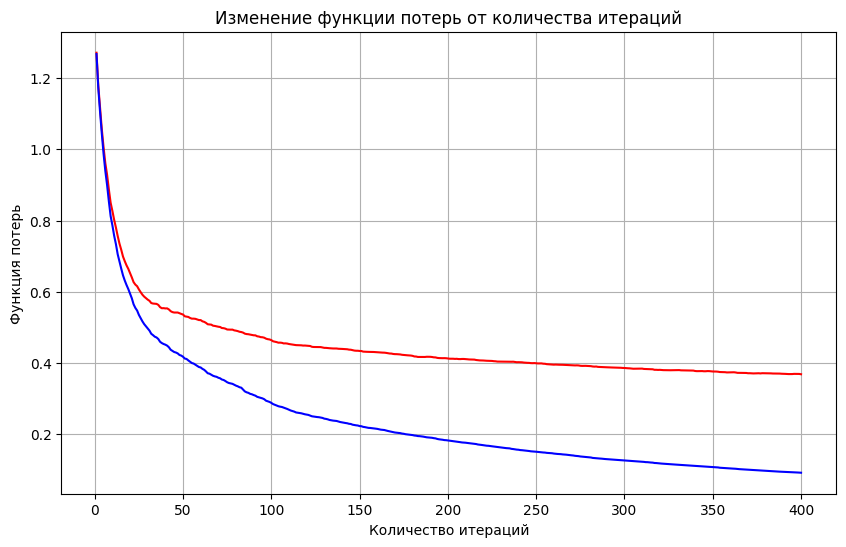

In [78]:
val_losses = CatBoost.get_evals_result()['validation']['MultiClass']
train_losses = CatBoost.get_evals_result()['learn']['MultiClass']
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(val_losses) + 1), val_losses, color='red')
plt.plot(np.arange(1, len(train_losses) + 1), train_losses, color='blue')
plt.xlabel('Количество итераций')
plt.ylabel('Функция потерь')
plt.title('Изменение функции потерь от количества итераций')
plt.grid(True)
plt.show()

In [79]:
y_pred = CatBoost.predict(X_test)
f2_score = fbeta_score(y_test, y_pred, beta=2, average='macro')
print("F2-мера:", f2_score)

F2-мера: 0.866933480529298


### adaboost

In [83]:
from sklearn.ensemble import AdaBoostClassifier

AdaBoostClassifier = AdaBoostClassifier(n_estimators=150, random_state=42)
AdaBoostClassifier.fit(X_train, y_train)

y_pred = AdaBoostClassifier.predict(X_test)

In [84]:
y_pred = AdaBoostClassifier.predict(X_test)
f2_score = fbeta_score(y_test, y_pred, beta=2, average='macro')
print("F2-мера:", f2_score)

F2-мера: 0.5969420058165641


# обучение моделей lda (gbm, adaboost)

In [85]:
X_train, X_test, y_train, y_test = train_test_split(lda_vec, target, test_size=0.2, random_state=42)

## gbm

In [86]:
train_pool = Pool(X_train, label=y_train)
test_pool = Pool(X_test, label=y_test)

CatBoost = CatBoostClassifier(iterations=150, learning_rate=0.1, random_seed=42, loss_function='MultiClass')
CatBoost.fit(train_pool, eval_set=test_pool, verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

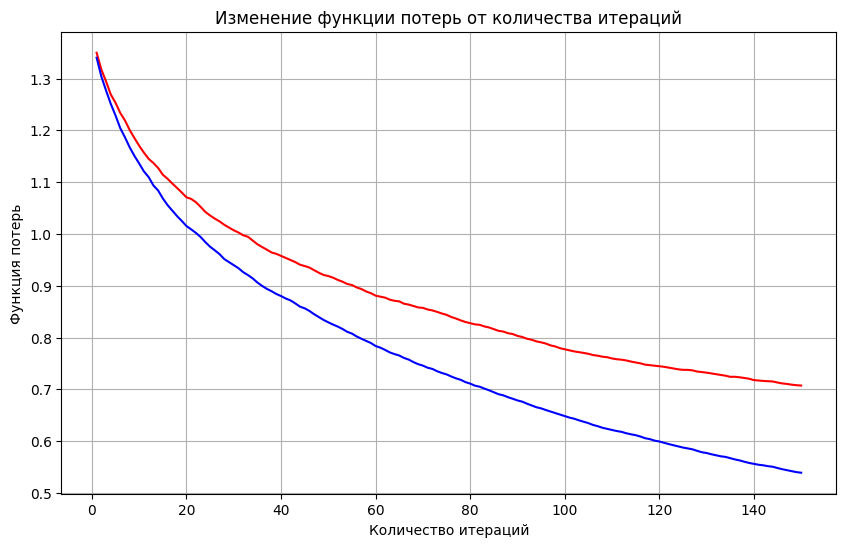

In [87]:
val_losses = CatBoost.get_evals_result()['validation']['MultiClass']
train_losses = CatBoost.get_evals_result()['learn']['MultiClass']
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(val_losses) + 1), val_losses, color='red')
plt.plot(np.arange(1, len(train_losses) + 1), train_losses, color='blue')
plt.xlabel('Количество итераций')
plt.ylabel('Функция потерь')
plt.title('Изменение функции потерь от количества итераций')
plt.grid(True)
plt.show()

In [88]:
y_pred = CatBoost.predict(X_test)
f2_score = fbeta_score(y_test, y_pred, beta=2, average='macro')
print("F2-мера:", f2_score)

F2-мера: 0.7744389853340543


## adaboost

In [89]:
from sklearn.ensemble import AdaBoostClassifier

AdaBoostClassifier = AdaBoostClassifier(n_estimators=150, random_state=42)
AdaBoostClassifier.fit(X_train, y_train)

y_pred = AdaBoostClassifier.predict(X_test)

In [90]:
y_pred = AdaBoostClassifier.predict(X_test)
f2_score = fbeta_score(y_test, y_pred, beta=2, average='macro')
print("F2-мера:", f2_score)

F2-мера: 0.6005525412599838


# Результаты

In [92]:
import pandas as pd

data = {
    'random forest': [0.7916930308972283, 0.6106153023551465],
    'gbm': [0.866933480529298, 0.7744389853340543],
    'adaboost': [0.5969420058165641, 0.6005525412599838]
}

df = pd.DataFrame(data)

df.index = ['lsi','lda']

df

,random forest,gbm,adaboost
lsi,0.791693,0.866933,0.596942
lda,0.610615,0.774439,0.600553
